# EMG Pipeline #

This notebook is to demonstrate the pipeline for EMG source inversion.

# Imports #
These should be covered in `requirements.txt`- activate the virtual environment `.venv` for the Python kernel and then make sure that environment has installed `pip install -r requirements.txt`. 

In [78]:
from scipy.constants import epsilon_0
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as K0, iv as I0
from scipy.linalg import solve, pinv, svd

from EMGinv_fns import *
from geometry_utilities import *
from plotter_utility_functions import plot_annotated_template_slice, plot_waveform_grid

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import minimize

import pandas as pd
import scipy.io
import mat73
from pathlib import Path
import shutil
import os, datetime
import os.path as op
import mne

import gc
import matplotlib.animation as animation
import pydicom

# Remove magic commands if turning into a script
import pyvistaqt

# %matplotlib qt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Processing Flags #
Set flags/environment-like-variables here, which will be used in rest of the notebook to determine what to process and how.

In [79]:
EXPERIMENT = 'MCP05_2024_08_29_3' # SUBJ YYYY MM DD BLOCK convention in filename

NUM_ELECTRODES = 256
ARM = 'left'
# NUM_ELECTRODES = 128
# ARM = 'right'

# MIN_DIPOLE_DISTANCE = 7.0 #mm
MIN_DIPOLE_DISTANCE = 2.0 #mm

SAMPLE_RATE = 2000. # samples per second (from MUAPs file)

MASK_FILE = f'Data/{EXPERIMENT}_muaps_mask.mat'
TEMPLATES_FILE = f'Data/{EXPERIMENT}_muaps_templates.mat'
COVARIANCE_FILE = f'Data/{EXPERIMENT}_muaps_covariance.mat'
ARM_DICOM_FILENAME = 'Data/R_Forearm.dcm'

ELECTRODES_FILE = f'Data/{NUM_ELECTRODES}simparm-{ARM}_electrode_pos.npy'
MNE_FWD_SOLUTIONS_FILE = f'Data/simp_arm_{ARM}_{MIN_DIPOLE_DISTANCE}mm_{NUM_ELECTRODES}channel_{SAMPLE_RATE}Hz-fwd.fif'
EXTRACT_MUAPS_FROM_MASK = False;

In [80]:
# Loading source space and forward model generated in MNE-python, see Fwd_BEM_MNE.ipynb
# Load electrode positions
electrode_pos = np.load(ELECTRODES_FILE)

# Load forward model
mne_fwd = mne.read_forward_solution(MNE_FWD_SOLUTIONS_FILE)
fwd = mne_fwd['sol']['data']
pos = mne_fwd['source_rr'] 
xscaling, yscaling, zscaling = (MIN_DIPOLE_DISTANCE*1e-3, MIN_DIPOLE_DISTANCE*1e-3, MIN_DIPOLE_DISTANCE*1e-3) # Is the distance between dipoles in source space #np.repeat(np.abs(np.sum(np.diff(pos[0], axis = 0))),3)  

# Removal of dipole sources - here remove sources lying within cylinders representing bone
pos, fwd = bone_remover(pos, fwd, -9e-3, 0, 5e-3) #Ulnar
pos, fwd = bone_remover(pos, fwd, 5e-3, -9e-3, 5e-3) # Radius

# Consider fwd model adjustments
# Condense the fwd such that there is only one dipole per voxel
dipole_ori = [0, 0, 1]
fwd = fwd_convertfixed(fwd, dipole_ori )

Reading forward solution from c:\MyRepos\Python\CMU_EMGSL\Data\simp_arm_left_2.0mm_256channel_2000.0Hz-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (23424 sources, 256 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [81]:
fwd.shape

(128, 20654)

In [30]:
# Alternative: Loading source space and forward model generated from (MRI) image data
# # Load electrode positions
# electrode_pos = np.load('electrode_pos.npy')

# # Load source space 
# xscaling, yscaling, zscaling = 1.5e-4, 1.5e-4, 0.5e-2
# pos = load_src_template(filename=None, xscaling=xscaling, yscaling=yscaling, zscaling=zscaling)

# # Load forward model
# fwd = np.load('Data/fwd_dipole.npy')
# # Alternative would be to generate with
# # fwd = fwd_generator(dipole_potential, pos, electrode_positions)
# # And then saving with np.save('fwd_dipole.npy', fwd) - Very big file

# # Consider fwd model adjustments
# # Condense the fwd such that there is only one dipole per voxel
# dipole_ori = [0, 0, 1]
# fwd = fwd_convertfixed(fwd, dipole_ori )

# # Adjust the fwd to remove some outliers
# # fwd[fwd>1e15] = 1e15
# # fwd = np.log10(fwd+1)  # this doesn't preserve sign
# fwd[np.isnan(fwd)] = 0 # for any nans

In [82]:
# Alternative to muaps_from matlab.mat - Load the mask, and then extract from the relevant EMG channels in MNE_raw
# MASK_FILE = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/muaps_mask.mat'
if EXTRACT_MUAPS_FROM_MASK:
    # Load some data - to construct covariance matrices
    # MNE_raw = load_tmsitomne_combine(f_prox = 'Data/Pok_2024_08_21_A_PROX_8.poly5', f_dist='Data/Pok_2024_08_21_B_DIST_8.poly5', scale=1e-6)
    MNE_raw = load_tmsitomne_combine(f_prox = 'C:/Data/MetaWB/MCP04_2024_09_17/TMSi/MCP04_2024_09_17_A_PROX_3.poly5', 
                                    f_dist='C:/Data/MetaWB/MCP04_2024_09_17/TMSi/MCP04_2024_09_17_B_DIST_3.poly5', 
                                    scale=1e-6, 
                                    trigger_bit = 1)
    # Important to filter the data (highpass filter)
    MNE_raw = MNE_raw.filter(l_freq=100, h_freq=None, )
    # Estimate the noise covariance matrix on Epoched data.  This means that the noise covariance will be estimated on pre-stimulus periods
    # events = tmsi_eventextractor(MNE_raw['Prox - TRIGGERS'][0][0] - 252) # Pok data
    events = tmsi_ttl_eventextractor(MNE_raw['Prox - TRIGGERS'][0][0], trigger_bit=1) 
    print(events)
    # event_dict = {'Ext': -2, 'Flex': -6} # Should be correct 
    event_dict = {'Rest': 0, 'Go': 1} # MCP04 data
    epochs = mne.Epochs(MNE_raw, events, event_dict, tmin=-4, tmax=4, baseline=None, preload=True)
    # Set tmin and tmax based on experimental conditions.  In this case, the participant was not moving perfectly to the triggers.
    noise_cov = mne.compute_covariance(epochs, method='auto', tmin=-2, tmax=0.01)
    data_cov = mne.compute_covariance(epochs, method='auto', tmin=1, tmax=epochs.tmax)

    noise_cov.plot(epochs.info,);
    data_cov.plot(epochs.info,);
    mask = scipy.io.loadmat(MASK_FILE)['mask']
    # Not sure why some of the masks aren't in the data - and why the end result is so different
    mask = mask[:-2, :]
    data = MNE_raw.get_data(picks='data')
    # Need to get component for all channels
    muaps = np.zeros((128,41))
    for i in range(128):
        tmp = data[i,:]
        snips = tmp[mask]
        muaps[i,:] = np.mean(snips, axis=0)
    del MNE_raw, epochs, tmp, snips, data
    gc.collect()
else:
    muaps = scipy.io.loadmat(TEMPLATES_FILE)['muaps']
    noise_cov = scipy.io.loadmat(COVARIANCE_FILE)['noise_cov']
    data_cov = scipy.io.loadmat(COVARIANCE_FILE)['data_cov']


In [83]:
# Beamformer - for online processing - Note max_power is only for use when dipole orientation is unknown

w_lcmv = lcmv_beamformer_constructor(fwd, data_cov=data_cov.data, noise_cov= noise_cov.data, pos=pos, arr_gain=True, max_power=False)

# Choose the waveform to use - muaps, ext_1, flex_1
waveform = muaps

# Apply beamformer
source_activity_time = np.dot(w_lcmv, waveform)

In [84]:
# Alternative algorithms, can consider looking at minimum norm estimate:

# Minimum norm estimate
# source_activity_time = minimum_norm_estimate(fwd, waveform, noise_cov=noise_cov.data, reg=0.1)

# sLoreta
# source_activity_time = sloreta(fwd[:N,:], waveform, noise_cov=noise_cov, reg=0.1)

# Different optimisers for ECD (Equivalent Current Dipole) fitting - Which did not work too well
# n_dipoles = 1
# data = muaps[:, 20]
# N=data.shape[0]
# optimal_dipoles = ECD_fit_dipoles(data, fwd[:N,:]/np.linalg.norm(fwd[:N,:]), pos, n_dipoles, initial_guess=np.array([0.05, 0.09, 0.03, 1, 1, 1]), local=True) # 
# optimal_dipoles = ECD_fit_dipoles_analytical(data, electrode_pos[:N,:], n_dipoles, local=True)
# print("Optimal dipole parameters (position, strengths):", optimal_dipoles)

# Best dipole in fwd
# best_index, best_weights, save_arr = best_dipole_infwd(fwd, muaps)
# Pos as obtained from:
# pos[best_index[t],0], pos[best_index[t],1], pos[best_index[t],2]

# Visualisations
From here onward, we are just viewing the data in different ways.

## View Time-Domain Inputs ##

<Figure size 640x480 with 0 Axes>

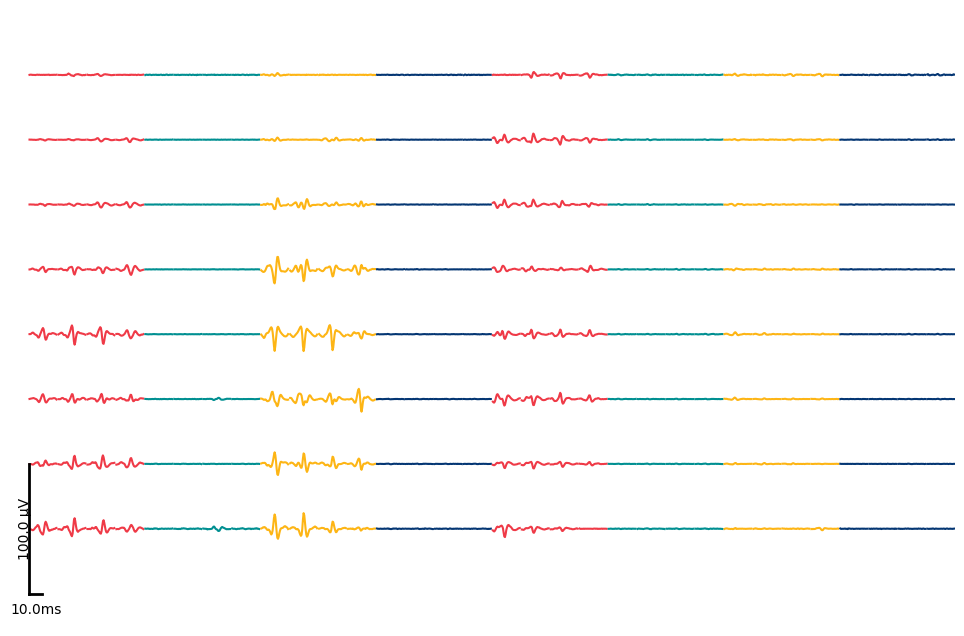

In [85]:
plt.figure()
plot_waveform_grid(waveform.T, fs=SAMPLE_RATE, cols=NUM_ELECTRODES/8, row_spacing=50.0)

Text(0.5, 0.92, '256-Channel 20654-Dipole LCMV Beamformer')

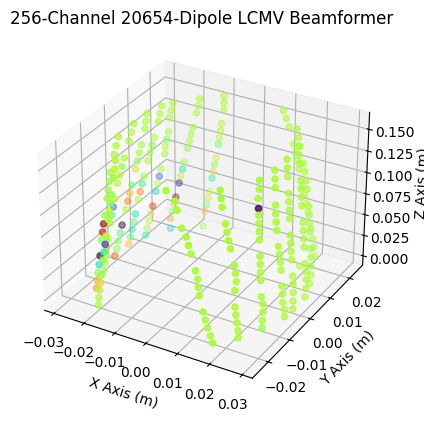

In [86]:
# Threshold
thresh = 0.5
# Look at specific timepoint in the source activity - 20 for matlab template waveform, 30 for other one; ext_1 - 5s and 15s are interesting; flex_1 - 9s
t = 20

source_activity = source_activity_time[:, t]

# Reshape source activity to condense N source orientations into 1 per voxel - Confirmed works for 3 orientations, should work for more.
reshape_by = source_activity.shape[0] // pos.shape[0]
reshaped_act = np.array(source_activity.reshape((reshape_by, -1), order='F'))
source_activity = np.linalg.norm(reshaped_act, axis=0)

ind = np.abs(source_activity) > thresh*np.max(np.abs(source_activity))
source_activity = source_activity[ind]
pos_t = pos[ind]

# Plot the convex hull and the moved points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot electrode positions
ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c=waveform[:,t], marker='o', cmap='turbo')
# Plot the source space
ax.scatter(pos_t[:, 0], pos_t[:, 1], pos_t[:, 2], c=source_activity, marker='o', alpha=0.8, cmap='viridis')
# Set labels
ax.set_xlabel('X Axis (m)')
ax.set_ylabel('Y Axis (m)')
ax.set_zlabel('Z Axis (m)')
n_channels, n_sources = fwd.shape
ax.set_title(f'{n_channels}-Channel {n_sources}-Dipole LCMV Beamformer')


Palm-side in this plot is `-z` axis. Electrode rings are oriented in the `xy` plane, with `y` displaying proximal to distal.

In [87]:
x_min, x_max = np.min(pos[:, 0]), np.max(pos[:, 0])
y_min, y_max = np.min(pos[:, 1]), np.max(pos[:, 1])
z_min, z_max = np.min(pos[:, 2]), np.max(pos[:, 2])

In [88]:
# ARM_DICOM_FILENAME = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/R_Forearm.dcm'
# Load arm MRI file
ds = pydicom.dcmread(ARM_DICOM_FILENAME)
arm_image = ds.pixel_array

IndexError: index 26 is out of bounds for axis 0 with size 26

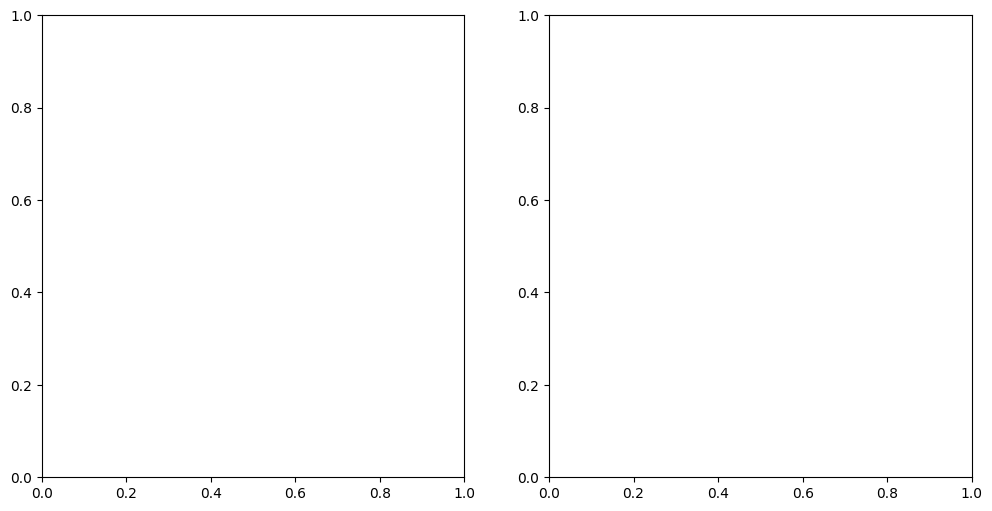

In [100]:
# Create a unique folder based on the current runtime
z = 84
save_dir = f'Animations/{EXPERIMENT}/z{z}mm'
os.makedirs(save_dir, exist_ok=True)  # Create the folder if it doesn't exist
# Exemplar grid slice index along the long-axis of arm model, from proximal aspect.
# NOTE: This number is multiplied by the MIN_DIPOLE_DISTANCE value to get the distance from
#       the proximal aspect of the arm model, in millimeters. From there, to reconcile with the 
#       labels file, which has a fixed slice thickness, we need to do some rescaling.


for t in range(41):
    source_activity = source_activity_time[:, t]

    # Faster to reconfigure the scatter points to be in a grid, and then use imshow to plot the activity.
    grid = pos_to_3Dgrid_converter(pos, source_activity, (xscaling, yscaling, zscaling))

    # Create a figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # MRI visualization on the left subplot
    img = axs[0].imshow(arm_image[z * arm_image.shape[0] // grid.shape[2], 100:500, 330:670, 2], 
                        extent=[y_min, y_max, x_min, x_max], cmap='gray', origin='upper')
    scatter_left = axs[0].scatter(electrode_pos[:, 0], electrode_pos[:, 1], c=waveform[:, t], cmap='turbo', marker='o')
    axs[0].set_title('MRI for visualization of orientation only')
    axs[0].set_xlabel('X Axis (m)')
    axs[0].set_ylabel('Y Axis (m)')
    axs[0].axis('on')
    # plt.colorbar(scatter_left, ax=axs[0], label='Electrode Activity')  # Associate the colorbar with the scatter plot

    # Source estimate on the right subplot
    img_source = axs[1].imshow(grid[:, :, z], origin='upper', cmap='viridis', extent=[y_min, y_max, x_min, x_max],
                               vmin=0, vmax=3)  # Clamping the colorbar scale
    scatter_right = axs[1].scatter(electrode_pos[:, 0], electrode_pos[:, 1], c=waveform[:, t], cmap='turbo', marker='o')
    axs[1].set_title('Source Estimate')
    axs[1].set_xlabel('X Axis (m)')
    axs[1].set_ylabel('Y Axis (m)')
    plt.colorbar(img_source, ax=axs[1], label='Source Activity')  # Associate the colorbar with the imshow (source estimate)

    # Example call to annotate the slice with landmarks
    options = {
        'FileExpression': "C:/Data/Anatomy/Human Arm/Sections/R_Forearm_Section_%d.png",
        'LandMarksFile': "C:/Data/Anatomy/Human Arm/Sections/Landmarks.xlsx",
        'LandMarkSheetExpression': "R_Forearm_Section_%d",
        'LandmarksToAdd': ["ALL"],
        'GridColumns': grid.shape[1],
        'GridRows': grid.shape[0],
        'GridColumnLeftOffset': 100,
        'GridColumnRightOffset': 500,
        'GridRowTopOffset': 330,
        'GridRowBottomOffset': 670,
        'XScale': 0.003,
        'YScale': -0.002,
        'XOffset': -0.0575,
        'YOffset': -0.005,
        'MillimetersPerSection': 8.5, 
        'AddLabels': True,
        'AddImage': False
    }

    # Plot the annotated landmarks on the right subplot (source estimate plot)
    plot_annotated_template_slice(axs[1], z, options)

    # Adjust the layout
    plt.tight_layout()

    # Save the figure to a file in the created folder
    plt.savefig(f'{save_dir}/frame_{t:03d}.png', dpi=300)

    # Close the figure to save memory
    plt.close(fig)

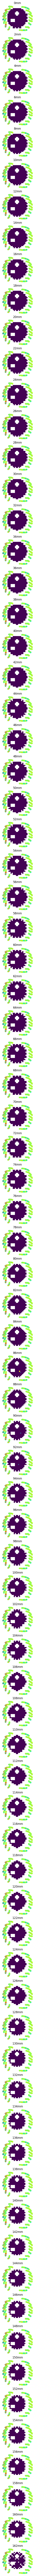

In [92]:
# Plot all the slices
# This is hard to use when there are too many slices!  May need to change the matplotlib viewer if too many slices
# %matplotlib inline

num_slices = grid.shape[2]

# Create subplots
fig, axes = plt.subplots(num_slices, 1, figsize=(8, 200))

# Plot each slice
for z in range(num_slices):
    # Plot activity
    axes[z].imshow(grid[:,:,z], extent=[y_min, y_max, x_min, x_max], origin='upper', cmap='viridis', vmin=0, vmax=np.nanmax(grid) )
    # Plot electrode position
    axes[z].scatter(electrode_pos[:, 0], electrode_pos[:, 1], c=waveform[:,t], cmap='turbo', marker='o')
    axes[z].set_title(f'{int(1000*z*zscaling)}mm')
    axes[z].axis('off')

# Display the plot
# plt.tight_layout()
plt.show()

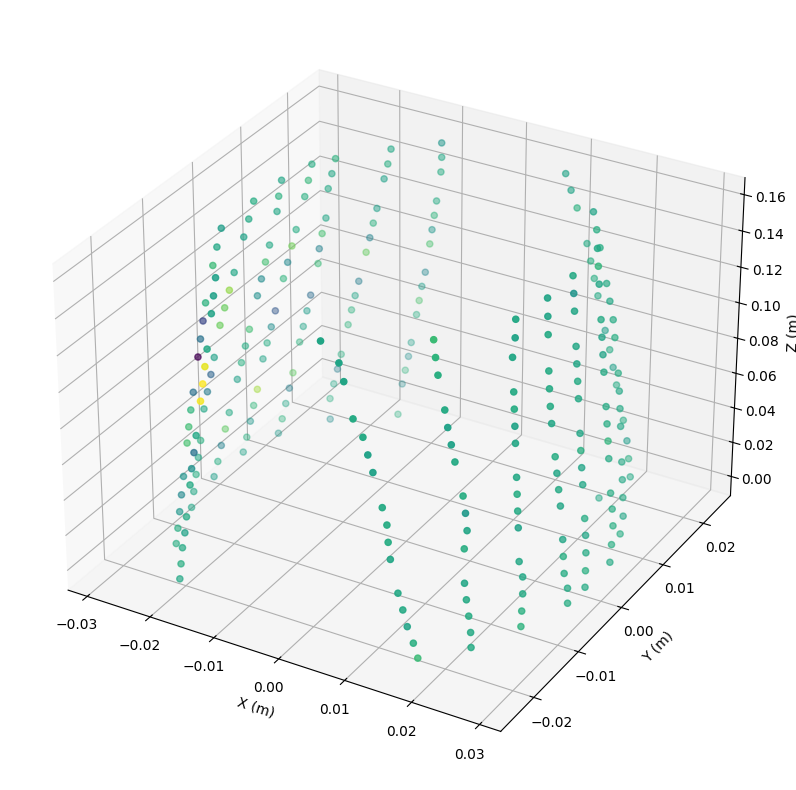

In [91]:
# If want to do 3D animated plot

best_index = 20

def update_plot(i, data, scat, ):
    scat.set_array(data[i])
    ax.set_title(f'Timepoint {i}')
    return scat,

numframes = muaps.shape[1]
colour_data = muaps.T
pos_move = pos[best_index,:]

# Plot 3D image of electrode positions and select dipole positions

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the electrode positions
p = ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c=muaps[:,0], marker='o', ) #vmin=muaps.min(), vmax=muaps.max())
# fig.colorbar(p, ax=ax)
# Colourbar and vmin and vmax may not be useful as only one electrode may seem to change colour
# p2 = ax.scatter(pos[best_index[:],0], pos[best_index[:],1], pos[best_index[:],2], c='r', marker='x', s=50, )

# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
                                fargs=(colour_data, p, ))
plt.show()